# Mixture models and expectation maximization

In [1]:
import numpy as np
import scipy.stats as sps
import scipy.optimize as spo

import matplotlib.pyplot as plt
import seaborn as sns

## Tutorial content

1. Generative model of a mixture of Gaussians: simulating data
2. Fit the mixture model: Implementation of Expectation Maximization algorithm.

BONUS: Analytical vs numerical solution and custom mixture models.

# 0. Intro

## 0.1. Simulated setup

In this tutorial, we will simulate and model trialwise saccade endpoints in a bandit-like decision making task. Assume that the value of objects fluctuates. Choices are made by making a saccade to one of three objects on a screen.

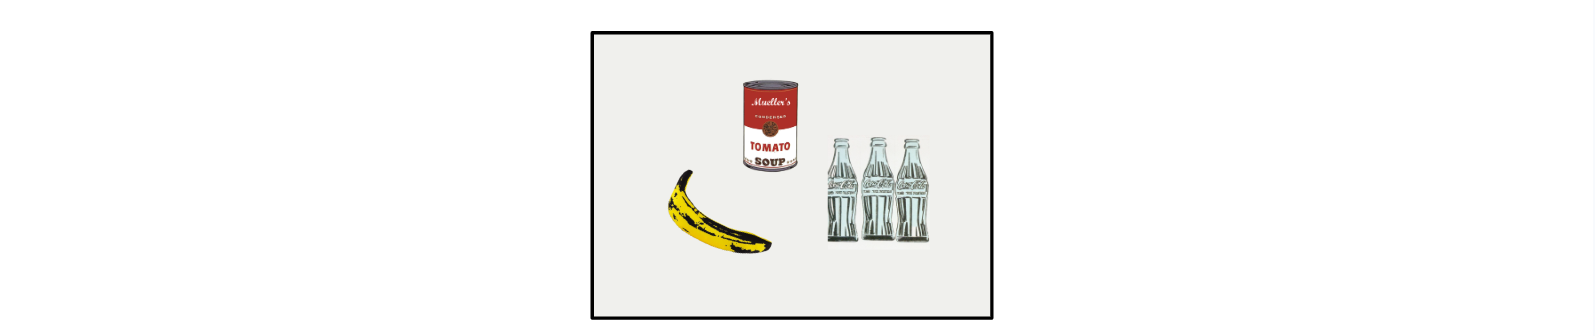

We are interested in analyzing trial-by-trial choices. We do not have access to explicit choice data, but only to an array of saccade endpoints $\boldsymbol{x} \in \mathbb{R}^{N x D}$ ($N$: number of trials, $D = 2$ : dimensionality of our data), corresponding to horizontal and vertical positions on the display.

## 0.2. Mixture of Gaussians

We assume that saccades are centered on the chosen object. However, eye-tracking data is noisy: Therefore, data is distributed around the center, following a 2D Gaussian for each of the three objects (A).

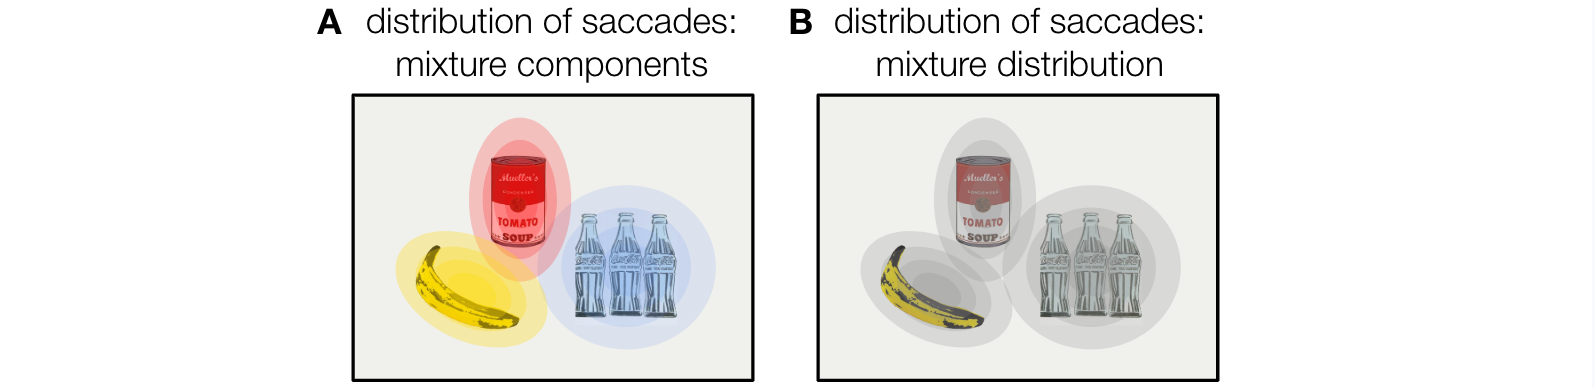

The experimenter of course only has access to 'unlabeled' saccades as in (B). The grey density is called a *Gaussian mixture distribution*, which is a weighted sum of the *mixture components* (i.e., the red, yellow, and blue Gaussians in (A)):

\begin{align}
p(\boldsymbol{x}) = \sum_{k=1}^{K} \pi_{k} \mathcal{N}(\boldsymbol{x} | \mu_k, \Sigma_k) 
\end{align}<div style="text-align: right"> Eq. (1) </div>

means $\mu_k$ and covariances $\Sigma_k$ and *mixing coefficients* $\pi_k$ for each class or component $k$.

# 1. The Gaussian mixture model as a generative model

We can think of the saccade generation as a hierarchical process, with two types of variables:

- The unobserved, **latent variable** $\boldsymbol{z} \in \{0,1\}^{K\times N}$ indicates the choice with one-hot-coding ($z_{nk} = 1$ if class $k$ in trial $n$, else $0$).
- The **observations** $\boldsymbol{x} \in \mathbb{R}^{N\times D}$, i.e. the 2D saccade endpoints. $\boldsymbol{x}$ depends on $\boldsymbol{z}$, reflected by the directed arrow below.

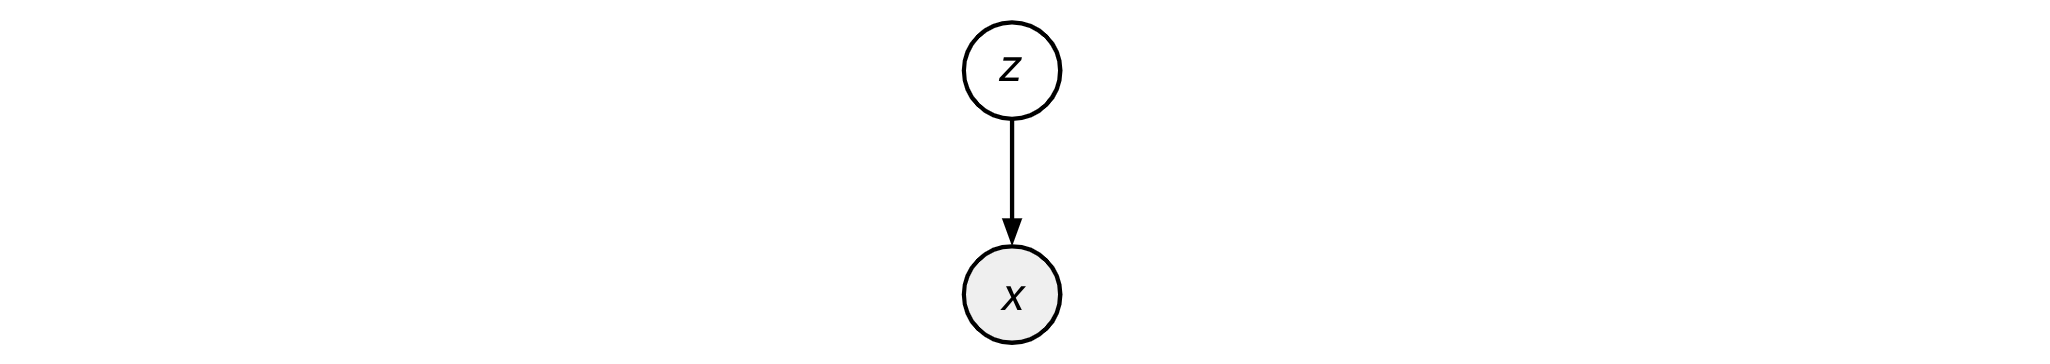

The full model is given as the joint distribution $p(\boldsymbol{x,z} | \theta) = p(\boldsymbol{x} |\boldsymbol{z}, \theta) p(\boldsymbol{z} | \theta)$, with parameters $\theta = \{\mu, \Sigma, \pi\}$. Marginalizing out $\boldsymbol{z}$ leads us back to Eq. (1).: 

\begin{align}
p(\boldsymbol{x} | \theta) = \sum_Z p(\boldsymbol{x}, \boldsymbol{z} | \theta) = \sum_Z p(\boldsymbol{z} | \theta) p(\boldsymbol{x} |\boldsymbol{z}, \theta) = \sum_{k=1}^{K} \pi_{k} \mathcal{N}(\boldsymbol{x} | \mu_k, \Sigma_k) 
\end{align}

In our experiment:
- the prior $p(z_k | \theta_k) = \pi_{k}$ is the average probability of choosing k,
- the mean and covariance of the class-conditional distribution $p(\boldsymbol{x} | z_k=1, \theta_k) = \mathcal{N}(\boldsymbol{x}|\mu_k, \Sigma_k)$ depend on the objects' shape and position, and subject-specific variability in saccades.

We will now use the generative model to simulate a dataset by randomly sampling $\boldsymbol{x}$ in $N = 1000$ trials from Eq. 1. We will assume for now that the subject chooses a random object in each trial, only based on prior probabilities $\pi_k$.

## 1.1. Ground truth parameters

In [2]:
# Hyperparameters
N = 1000
K = 3
D = 2

# screen borders
borders = np.array([[0,80], [0,60]])

# mixing coefficients: should sum to 1 so that if each mixture component is a density, 
# the full mixture distribution is also a density
pis = [.2, .35, .45]

# mus
mus = [np.array([20,20]), np.array([35,40]), np.array([60,25])]

# pick DxD covariance matrices for each Gaussian
# symmetric with small covariances to ensure they are positive semidefinite
sigmas = [20*np.array([[1,-.4],[-.4,1]]), 
          40*np.array([[.5,0],[0,1]]), 
          40*np.array([[1,.1],[.1,1]])]

# set random seed for reproducibility
np.random.seed(0)

## 1.2. True values of latent variable $\boldsymbol{z}$

For each trial, simulate true choices. Create
- a vector `ks` of length $N$ encoding the classes, i.e. with values in $\{0,1,2\}$. Use `np.random.choice()`
- `zs`, i.e. the true value of the one-hot-coded latent variable $\boldsymbol{z} \in \{0,1\}^{K \times N}$

Plot $\boldsymbol{z}$ for the first 100 trials.

In [3]:
# make vector of true class identities
ks = np.array([np.random.choice(3, p=pis) for _ in range(N)])

# make K x N array for true values of z
z_values = [[1,0,0], [0,1,0], [0,0,1]]
zs = np.array([z_values[k] for k in ks]).T

Text(0.5, 1.0, 'true value of latent variable $z_{nk}$')

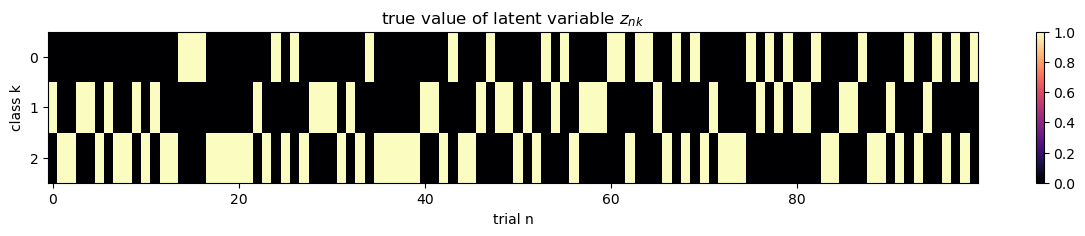

In [4]:
plt.figure(figsize=(15,2), dpi=100)
plt.imshow(zs[:,:100], aspect='auto', interpolation='none', cmap='magma')
plt.colorbar()
plt.ylabel('class k')
plt.xlabel('trial n')
plt.title(r'true value of latent variable $z_{nk}$')

## 1.3. Sample observations $\boldsymbol{x}$

Sample $N=1000$ saccades from class-conditional multivariate Gaussians (i.e., using ground truth class-specific `mu` and `sigmas`), using the function `sps.multivariate_normal.rvs()`. Note that in code, it is usually easier to us `ks` as a class index than `zs`.

Plot the mixture distribution of saccades by uncommenting the pre-written code.

In [5]:
# simulate saccades depending on k_n
saccades = np.array([sps.multivariate_normal.rvs(mus[ks[n]], sigmas[ks[n]], 1) for n in range(N)])

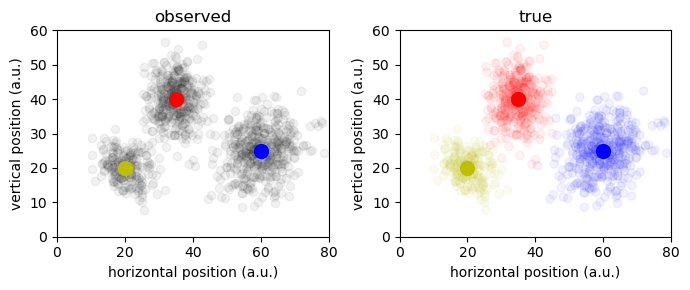

In [6]:
# plot data
colors = ['y', 'r', 'b']

plt.figure(figsize=(7,3), dpi=100)
plt.subplot(1,2,1)
plt.scatter(saccades[:,0], saccades[:,1], c='k', alpha=.05)
for mi,m in enumerate(mus):
    plt.plot(m[0], m[1], 'o', color=colors[mi], ms=10)
plt.xlim(borders[0])
plt.ylim(borders[1])
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.title('observed')

plt.subplot(1,2,2)
plt.scatter(saccades[:,0], saccades[:,1], 
            c=[colors[k] for k in ks], alpha=.05)
for mi,m in enumerate(mus):
    plt.plot(m[0], m[1], 'o', color=colors[mi], ms=10)
plt.xlim(borders[0])
plt.ylim(borders[1])
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.title('true')
plt.tight_layout()

# 2. Fitting Gaussian mixture models

We now treat the ground truth as if it were a real dataset: We pretend we only have access to observations $\boldsymbol{x}$. Based on the data, we will infer:

- the values of latent variable $\boldsymbol{z_n}$ for each observation $x_n$
- parameters $\theta_k = \{\mu_k, \Sigma_k, \pi_k$\} for each component $k$

Importantly, we cannot infer these parameters and variables independently of each other (they are connected in the graph!). *Iterative algorithms* like **expectation maximization (EM)** solve this problem by dividing it into two sub-problems.

<div class="alert alert-block alert-info"> <b>The expectation maximization (EM) algorithm</b> 

EM iteratively estimates 1) the posterior over latent variables and 2) the optimal model parameters. The steps are:


0. **Initialization**: Choose parameters $\theta^{0}$ for iteration $i = 0$.
1. **E step: Best guess for values of the latent variable $\boldsymbol{z}$.** \
   We calculate the *posterior probabilities* $p(\boldsymbol{z} | \boldsymbol{x}, \theta^i) \in [0,1]^{N,K}$ of data point $n$ belonging to class $k$, after having seen the data.
2. **M step: Update parameters $\boldsymbol{\theta}^{i+1}$ by maximizing the likelihood.** \
   To find new parameters  $\theta^{i+1}$, we should maximize the *complete-data log likelihood* $\ln p(\boldsymbol{x},\boldsymbol{z} | \theta)$ of our model. However, we don't know the values of $\boldsymbol{z}$. As a workaround, we will maximize the *expected complete-data log likelihood* under the posterior $p(\boldsymbol{z} | \boldsymbol{x}, \theta^{i})$:
   
   \begin{align}
   \mathbb{E}_{\boldsymbol{z}}[\ln p(\boldsymbol{x}, \boldsymbol{z}| \theta)] &= \sum_Z p(\boldsymbol{z} | \boldsymbol{x}, \theta^{i}) \ln p(\boldsymbol{x}, \boldsymbol{z}| \theta)
   \end{align}

Alternate E and M steps until the log likelihood converges. Run the algorithm several times with distinct initializations (0.) and pick the model with the highest log likelihood.
    
</div>

## 2.1. Initialization

In the Gaussian mixture model, $\theta_k = \{\mu_k,\Sigma_k, \pi_k\}$.

Write a function that randomly initializes parameters (within certain bounds, i.e. screen boundaries for $\mu$. For $\Sigma$, we choose positive diagonal entries and off-diagonal entries that are zero). 

Plot the resulting mixture distribution by evaluating the joint distribution (Eq. 1) at uniformly spaced values of $x$ (pre-coded as `vals`). Remember that $\mathcal{N}(x; \mu, \Sigma)$ can be evaluated by calling `sps.multivariate_normal.pdf(x, mu, sigma)`.

In [7]:
# function to initialize the GMM
def initialize_GMM(K, D, lower, higher, seed):
    
    np.random.seed(seed)
    
    # initialize means to random integers
    m = np.random.randint(low=lower, high=higher, size=(K, D))
    
    # initialize covariance to random integer on diagonal, 0 off-diagonal
    s = np.array([np.eye(D)*np.random.randint(low=np.max(higher)/4, high=np.max(higher)) 
                  for i in range(3)])
    
    # pick random numbers that sum to 1
    p = np.random.rand(3)
    p/= np.sum(p)
    
    return m, s, p

In [8]:
# pick random means, covariances, and mixing coefficients
m, s, p = initialize_GMM(K, D, lower=[0,0], higher=[80,60], seed=0)

print(m)

[[44 47]
 [64  3]
 [67 39]]


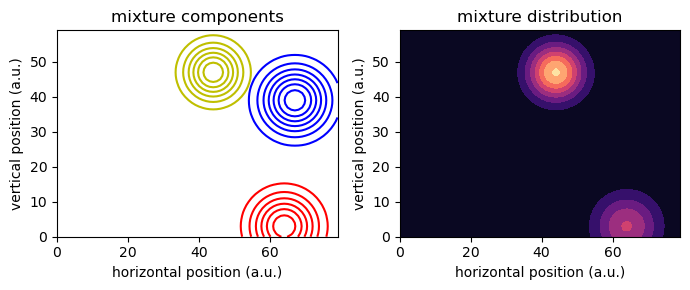

In [9]:
# plot initial means and covariances, as well as initial mixture distribution

# make 2D meshgrid
x, y = np.mgrid[0:80:1, 0:60:1]
vals = np.dstack((x, y))

# evaluate pdfs
pdfs = [sps.multivariate_normal.pdf(vals, m[k], s[k]) for k in range(K)]

# sum weighted pdfs for mixture distribution
mixture_pdf = np.sum([p[k]*pdfs[k] for k in range(K)], axis=0)

plt.figure(figsize=(7,3), dpi=100)
plt.subplot(1,2,1)
for k,pdf in enumerate(pdfs):
    plt.contour(pdf.T, colors=colors[k])
plt.title('mixture components')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')

plt.subplot(1,2,2)
plt.contourf(mixture_pdf.T, cmap='magma')
plt.title('mixture distribution')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.tight_layout()

## 2.2. E Step

Given the parameters at iteration $i$, $\theta^{i}$, and observations $\boldsymbol{x}$, what is the posterior distribution $p(\boldsymbol{z} | \boldsymbol{x}, \theta^i)$?

<div class="alert alert-block alert-info"> <b>Calculating the posterior</b> 
    
Following Bayes theorem, we can write the posterior as:

\begin{align}
p(\boldsymbol{z}|\boldsymbol{x},\theta) &= \frac{p(\boldsymbol{x}|\boldsymbol{z}, \theta) p(\boldsymbol{z} |\theta)}{p(\boldsymbol{x} | \theta)} 
                = \frac{p(\boldsymbol{x}|\boldsymbol{z}, \theta) p(\boldsymbol{z} |\theta)}{\sum_Z p(\boldsymbol{x}, \boldsymbol{z} | \theta)} 
                = \frac{p(\boldsymbol{x}|\boldsymbol{z}, \theta) p(\boldsymbol{z} |\theta)}{\sum_Z p(\boldsymbol{x} | \boldsymbol{z}, \theta) p(\boldsymbol{z} |\theta)}
\end{align}

</div>

For Gaussian mixtures, this translates to calculating the probability $p(z_{nk}=1|\boldsymbol{x}_n, \theta^{i})$ that observation $x_n$ in trial $n$ was sampled from distribution $k$ with parameters $\theta_k^{i} = \{\mu_k^i, \Sigma_k^i, \pi_k^i\}$ for iteration $i$. These probabilities are called the *responsibilities* $\gamma_{nk}$. 

\begin{align}
\gamma_{nk} = p(z_{nk}=1|\boldsymbol{x}_n, \theta)
            = \frac{\pi_k\mathcal{N}(\boldsymbol{x}_n|\mu_k, \Sigma_k)}{\sum^K_{j=1}\pi_j\mathcal{N}(\boldsymbol{x}_n|\mu_j, \Sigma_j)} 
\end{align}<div style="text-align: right"> Eq. (2) </div>

Write a function `GMM_estep(x, mu, sigma, pi)` that implements Eq. (2) to compute the responsibilities $\gamma_{nk}$.

In [10]:
def GMM_estep(data, m, s, p):
    K = m.shape[0]
    
    # joint p(x,z) = p(z)*p(x|z): prior * likelihood (evaluate pdf at each x_n). Should be K x N shaped
    numerator = np.array([p[k] * sps.multivariate_normal.pdf(data, m[k], s[k], allow_singular=True)
                          for k in range(K)])
    
    # marginal likelihood p(x) = sum_z( p(x,z) ) sum joint over K classes. vector of length N
    denominator = np.sum(numerator, axis=0)
    
    # posterior: p(x,z) / p(x)
    posterior = numerator/denominator

    return posterior

In [11]:
# calculate gammas
gammas = GMM_estep(saccades, m, s, p)

Text(0.5, 1.0, 'posterior $\\gamma_{nk}$')

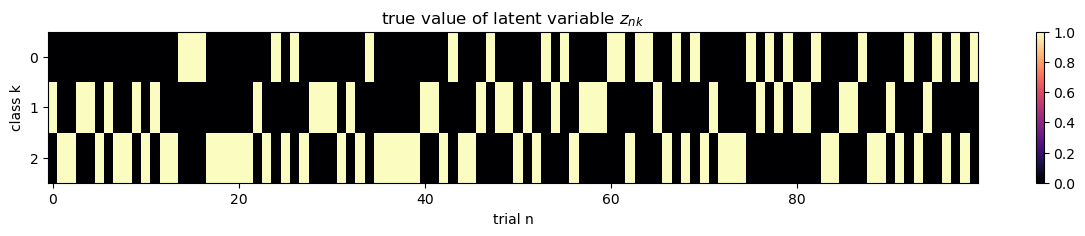

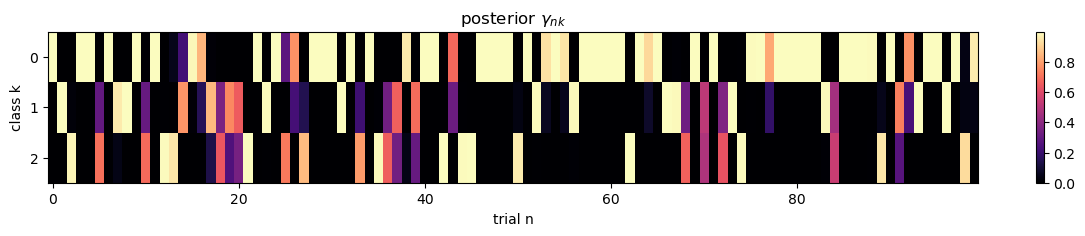

In [12]:
# plot
plt.figure(figsize=(15,2), dpi=100)
plt.imshow(zs[:,:100], aspect='auto', interpolation='none', cmap='magma')
plt.colorbar()
plt.ylabel('class k')
plt.xlabel('trial n')
plt.title(r'true value of latent variable $z_{nk}$')

plt.figure(figsize=(15,2), dpi=100)
plt.imshow(gammas[:,:100], aspect='auto', interpolation='none', cmap='magma')
plt.colorbar()
plt.ylabel('class k')
plt.xlabel('trial n')
plt.title(r'posterior $\gamma_{nk}$')

You will see that while $z_n \in \{ 0, 1\}$ is binary and one-hot encoded, $\gamma_n \in [0,1]$ containts floating-point numbers. Both are distributions (elements sum to 1 for each trial). Technically, we have $n$ true and posterior distributions over the latent variable.

## 2.3. Complete-data log likelihood

We will now calculate the expected complete-data log likelihood $\mathbb{E}_{\boldsymbol{z}}[\ln p(\boldsymbol{x}, \boldsymbol{z}| \theta)]$ under the posterior $p(\boldsymbol{z} | \boldsymbol{x}, \boldsymbol{\theta}^{i})$:

<div class="alert alert-block alert-info"> <b>Expected complete-data log likelihood</b> 

\begin{align}
  \mathbb{E}_{\boldsymbol{z}}[\ln p(\boldsymbol{x}, \boldsymbol{z}| \theta)] &= \sum_Z p(\boldsymbol{z} | \boldsymbol{x}, \theta^{i}) \ln p(\boldsymbol{x}, \boldsymbol{z}| \theta) \\
   &= \sum_Z p(\boldsymbol{z} | \boldsymbol{x}, \theta^{i}) \ln \{ p(\boldsymbol{x} | \boldsymbol{z}, \theta) p(\boldsymbol{z} | \theta) \}
   \end{align}

</div>
<div style="text-align: right"> Eq. (3) </div>

We will plug in the posterior $\gamma_{nk} = p(z_{nk} = 1 | \boldsymbol{x}_n, \theta^i_k)$ calculated in the E Step. Moreover, as before, $p(z_{nk} = 1 | \theta_k) = \pi_k$ and $p(\boldsymbol{x}_n | z_{nk} = 1, \theta_k) = \mathcal{N}(\boldsymbol{x}_n ; \mu_k, \Sigma_k)$. 

Write a function that takes the data, $\gamma$, and parameters $\theta^{i}$ and computes the expected log likelihood given by Eq. (3). To get back a scalar, sum the log likelihood over all datapoints after summing over classes.

*Tip*: If calculating log probabilities gives you `-inf`, you can use the numerically stable `sps.multivariate_normal.logpdf()` instead of `np.log(multivariate_normal.pdf()`.

To further avoid problems with numerical instability, set `allow_singular=True` when evaluating the pdf.

In [13]:
# log likelihood function
def GMM_log_LL(data, gammas, m, s, p):
    K = len(m)
    
    # first: evaluate log LL p(x|z), i.e. evaluate the pdf for each of the K components. Should be K x N shaped
    loglikes = np.array([sps.multivariate_normal.logpdf(data, m[k], s[k], allow_singular=True)
                     for k in range(K)])
    
    # multiply LL by prior and take log: log (p(x|z) * p(z)) . Still K x N shaped
    # then: multiply by gammas, E[z] * log (p(x|z) * p(z)) . also K x N shaped
    logprob = loglikes + np.log(p[:,np.newaxis])
    marginal_logprob = gammas * logprob
    
    # sum whole expression over K
    lls = np.sum(marginal_logprob, axis=0)
    
    # sum log likelihood of N single data points
    LL = np.sum(lls)
    
    return LL

In [14]:
LL_init = GMM_log_LL(saccades, gammas, m, s, p)
print(LL_init)

-13585.747617624756


## 2.4. M Step

The M-step consists of estimating $\theta^{i+1} = \{\mu^{i+1}, \Sigma^{i+1}, \pi^{i+1}\}$ that maximize this log likelihood function. We could tackle this parameter optimization problem by calling `spo.minimize()`, where our loss function would be the negative log likelihood, and our parameter vector a concatenation of all values in `mu, sigma` and `pis` (see BONUS for an implementation). However, mixtures of Gaussians allow for faster and more robust parameter updates with the analytical ('closed-form') solution.

To maximize the expected complete-data log likelihood $\mathbb{E}_{\boldsymbol{z}}[\ln p(\boldsymbol{x}, \boldsymbol{z}| \theta)]$, we set its derivative w.r.t. $\mu_k$, $\Sigma_k$, or $\pi_k$ to zero. We solve and get:

\begin{align}
\mu_k  &= \frac{1}{N_k} \sum^N_{n=1} \gamma_{nk} x_n \\
\Sigma_k &=  \frac{1}{N_k} \sum^N_{n=1} \gamma_{nk} (x_n-\mu_k)(x_n-\mu_k)^T \\
\pi_k &= \frac{N_k}{N}
\end{align}<div style="text-align: right"> Eq. (4-6) </div>


where $N_k$ is defined as $N_k = \sum^N_{n=1} \gamma_{nk}$. Write a function to update the parameters using Eqs. (4-6).

In [15]:
def GMM_mstep(data, g):
    K = g.shape[0]
    N = g.shape[1]
    D = data.shape[-1]

    # class-specific normalization constant: sum gammas over N
    Nk = np.sum(g, axis=-1)
    
    # mu: weight each of N data points by its gamma, then sum over N and normalize with N_k
    m = np.array([(1/Nk[k]) * np.sum(g[k]*data.T, axis=-1) 
                  for k in range(K)])
    
    # Sigma: K covariances of shape D x D
    s = np.zeros([K,D,D]) * np.nan
    
    # for each class and each sample N, 
    # take the dot product (x_n - mu_k) @ (x_n - mu_k).T, and sum over N
    for k in range(K):
        summation = 0
        for n in range(N):
            summation += g[k,n] * (data[n]-m[k])[:,np.newaxis]@(data[n]-m[k])[:,np.newaxis].T
        s[k,:,:] = summation/Nk[k]
        
#         # if a single datapoint is assigned to a class, variance becomes infinitely small --> reset
#         if Nk[k]<1:
#             print(Nk, s[k])
#             s[k,:,:] = np.eye(D)*100
    
    # pi
    p = Nk/N
        
    return m, s, p

In [16]:
# update mu, sigma, and pi parameters
m_new, s_new, p_new = GMM_mstep(saccades, gammas)

## 2.5. full EM algorithm

Write a loop that alternates E and M steps for 50 iterations. Repeat the algorithm for five different random initializations. 

Evaluate the expected complete-deta log likelihood at each iteration and plot the progress of log likelihoods over iterations for each initialization.

In [17]:
model = []
LLs = []

# several random initializations
for init in range(5):

    print(init)
    # pick random means, covariances, and mixing coefficients
    m, s, p = initialize_GMM(K, D, lower=[0,0], higher=[60,80], seed=init)
    
    # single E step to evaluate LL
    g = GMM_estep(saccades, m, s, p)
    LL = [GMM_log_LL(saccades, g, m, s, p)]

    # iterate 50 times
    for i in range(50):
        g = GMM_estep(saccades, m, s, p)
        m, s, p = GMM_mstep(saccades, g)
        LL.append(GMM_log_LL(saccades, g, m, s, p)) 
    
    model.append([g, m, s, p])
    LLs.append(LL)

0
1
2
3
4


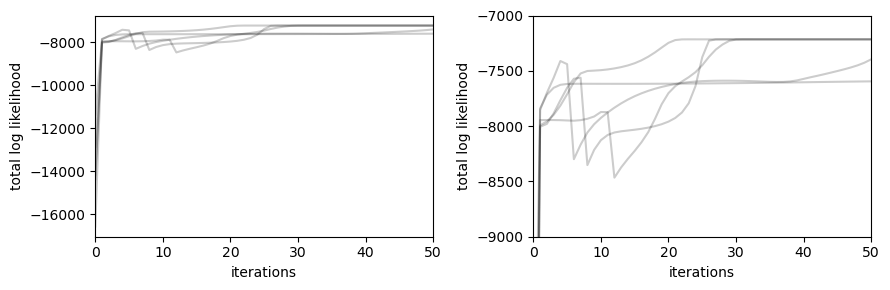

In [18]:
# plot log likelihoods for all random initializations to check if model converged
plt.figure(figsize=(9,3), dpi=100)
plt.subplot(1,2,1)
plt.plot(np.array(LLs).T, 'k-', alpha=.2)
plt.xlabel('iterations')
plt.ylabel('total log likelihood')
plt.xlim(0,50)
plt.subplot(1,2,2)
plt.plot(np.array(LLs).T, 'k-', alpha=.2)
plt.xlabel('iterations')
plt.ylabel('total log likelihood')
plt.xlim(0,50)
plt.ylim(-9000, -7000)
plt.tight_layout()

## 2.6. Model validation

Select the model with the highest final log likelihood. Plot true vs. estimated densities of single mixture components, as well as the full mixture distribution.

In [19]:
# select best model
best_model = np.argmax([ll[-1] for ll in LLs])
g, m, s, p = model[best_model]

Text(0.5, 1.0, 'expected value of the posterior $E_z[z_{nk}]$')

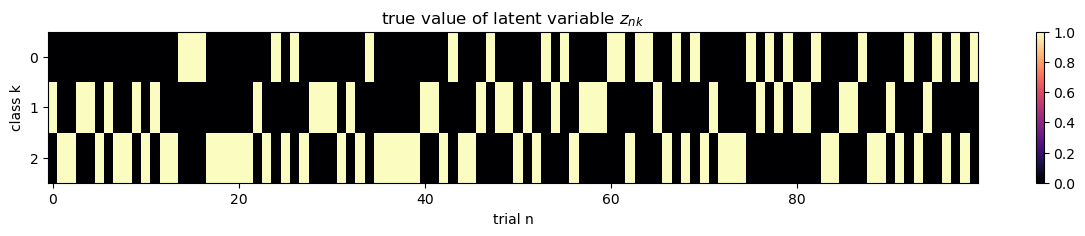

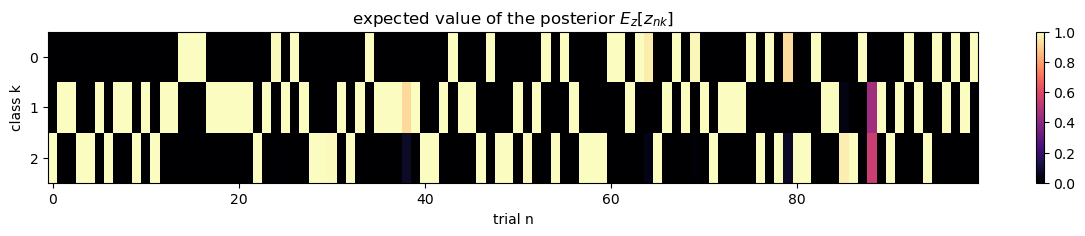

In [20]:
# plot true values of z (first 100 trials) and expected values of the posterior (first 100 trials)

plt.figure(figsize=(15,2), dpi=100)
plt.imshow(zs[:,:100], aspect='auto', interpolation='none', cmap='magma')
plt.colorbar()
plt.ylabel('class k')
plt.xlabel('trial n')
plt.title(r'true value of latent variable $z_{nk}$')

plt.figure(figsize=(15,2), dpi=100)
plt.imshow(g[:,:100], aspect='auto', interpolation='none', cmap='magma')
plt.colorbar()
plt.ylabel('class k')
plt.xlabel('trial n')
plt.title(r'expected value of the posterior $E_z[z_{nk}]$')

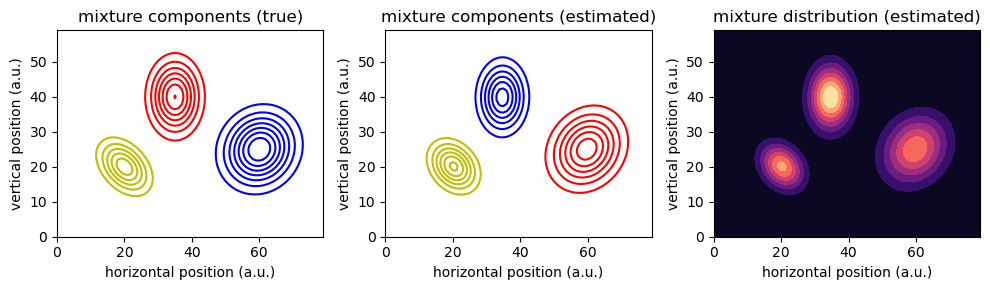

In [21]:
# plot final means and covariances, as well as final mixture distribution

# make 2D meshgrid
x, y = np.mgrid[0:80:1, 0:60:1]
vals = np.dstack((x, y))

# evaluate pdfs
pdfs = [sps.multivariate_normal.pdf(vals, m[k], s[k]) for k in range(K)]

# sum weighted pdfs for mixture distribution
mixture_pdf = np.sum([p[k]*pdfs[k] for k in range(K)], axis=0)

# true pdfs
pdfs_true = [sps.multivariate_normal.pdf(vals, mus[k], sigmas[k]) for k in range(K)]

plt.figure(figsize=(10,3), dpi=100)
plt.subplot(1,3,1)
for k,pdf in enumerate(pdfs_true):
    plt.contour(pdf.T, colors=colors[k])
plt.title('mixture components (true)')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')

plt.subplot(1,3,2)
for k,pdf in enumerate(pdfs):
    plt.contour(pdf.T, colors=colors[k])
plt.title('mixture components (estimated)')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')

plt.subplot(1,3,3)
plt.contourf(mixture_pdf.T, cmap='magma')
plt.title('mixture distribution (estimated)')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.tight_layout()

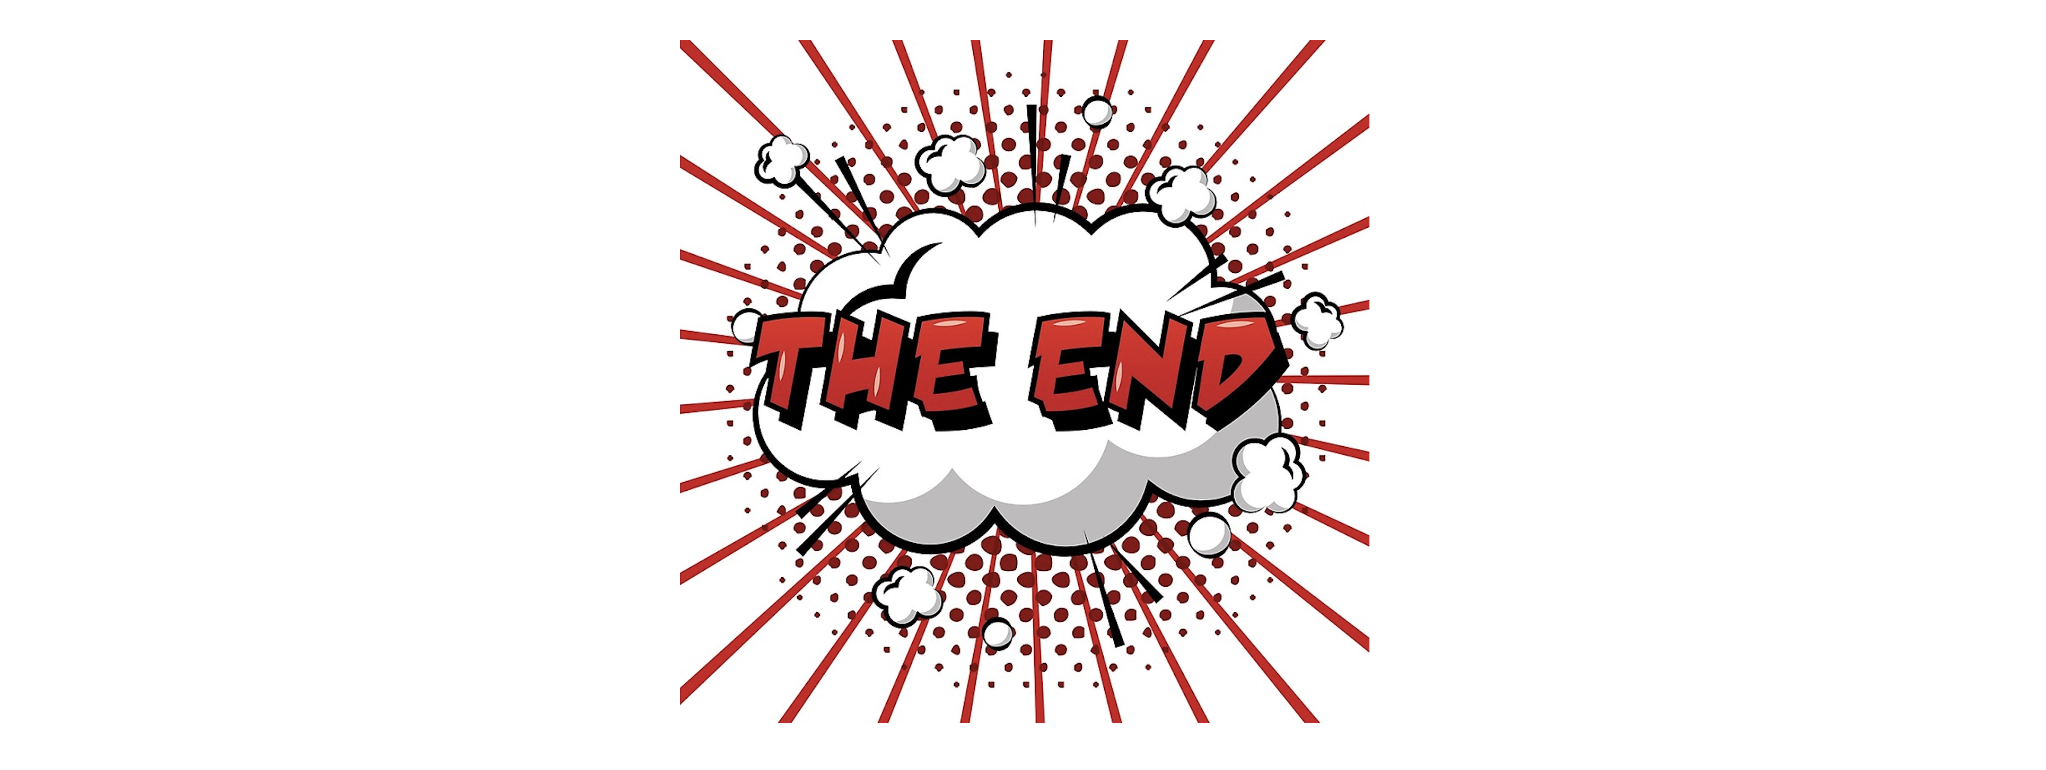

## What to do if there's no analytical solution (or we don't want to derive it)?

In the maximization step, we updated parameters to the maximum likelihood solution, which is obtained by setting the derivative of the log likelihood function $\mathbb{E}_{\boldsymbol{z}}[\ln p(\boldsymbol{x}, \boldsymbol{z}| \theta)]$ w.r.t. each parameter to zero and solving for the parameter of interest.

However, we could also use a less elegant, but sometimes more practical solution, where parameters are optimized numerically with `spo.minimize()` or similar methods. In the following, you can see an alternative implementation of the M-step. Note that parameter bounds help in finding stable solutions.

Numerical solutions are more flexible and can be used when it is difficult to obtain closed-form solutions.

In [22]:
def neg_log_LL(pars, data, g, p, D, K):
    
    # reconstruct K x D array of means
    m = pars[:K*D].reshape(K,D)
    
    # reconstruct K x D x D array of parameters for covariance matrix
    # Cholesky decomposition: to ensure symmetric positive definite covariance matrix, 
    # we decompose Sigma = LL^T
    # where L = [a, 0]
    #           [b, c]     with a and c positive
    # L is a lower triangular matrix with parameters L_tril = a,b,c
    L_tril = pars[K*D:].reshape(K,-1)

    s = np.zeros([K,D,D]) * np.nan
    
    for k in range(K):
        L = np.zeros([D,D])
        L[np.tril_indices(D)] = L_tril[k]
        s[k] = L@L.T

    nlogLL = -GMM_log_LL(data, g, m, s, p)
    
    return nlogLL


def GMM_numerical_mstep(data, g, m, s, p):
  
    K = m.shape[0]
    D = m.shape[1]

    # update pis
    p = np.mean(g, axis=1)

    m_reshape = m.reshape(-1)

    # for Sigma, we will use the Cholesky decomposition to ensure symmetry and positive definiteness
    # we decompose Sigma = LL^T
    # where L = [a, 0]
    #           [b, c]     with a and c positive

    # s_tril are parameters a,b,c
    L_tril = np.array([s[k][np.tril_indices(D)] for k in range(K)])
    L_reshape = L_tril.reshape(-1)

    x_start = np.concatenate([m_reshape, 
                              L_reshape])

    # set reasonable bounds
    bds = np.concatenate([
                          [(0,100)]*len(m_reshape), # bounds on mean for dim1 and dim2
                          [(.001,10), (-10,10), (.001,10)]*K # a,b,c for L in Sigma = LL^T
                          ])

    # call spo.minimize() on negative LL
    res = spo.minimize(neg_log_LL, 
                       x0=x_start, bounds=bds, 
                       args=(data, g, p, D, K),
                       method='L-BFGS-B') #'SLSQP')

    newpars = res.x

    # reconstruct K x D array of means
    m = newpars[:int(K*D)].reshape(K,D)

    # reconstruct K x D x D array of covariance matrices
    L_tril = newpars[K*D:].reshape(K,-1)

    s = np.zeros([K,D,D]) * np.nan

    for k in range(K):
        # Cholesky decomposition: to ensure symmetric positive definite covariance matrix, 
        # we decompose Sigma = LL^T
        # where L = [a, 0]
        #           [b, c]     with a and c positive
        L = np.zeros([D,D])
        L[np.tril_indices(D)] = L_tril[k]
        s[k] = L@L.T

    return m, s, p

In [23]:
model = []
LLs = []

# several random initializations
for init in range(5):
    print(init)

    # pick random means, covariances, and mixing coefficients
    m, s, p = initialize_GMM(K, D, lower=[0,0], higher=[60,80], seed=init)

    # single E step to evaluate initial LL
    g = GMM_estep(saccades, m, s, p)
    LL = [GMM_log_LL(saccades, g, m, s, p)]

    # iterate 50 times
    for i in range(50):
        g = GMM_estep(saccades, m, s, p)
        m, s, p = GMM_numerical_mstep(saccades, g, m, s, p)
        LL.append(GMM_log_LL(saccades, g, m, s, p)) 
    model.append([m, s, p])
    LLs.append(LL)

0
1
2
3
4


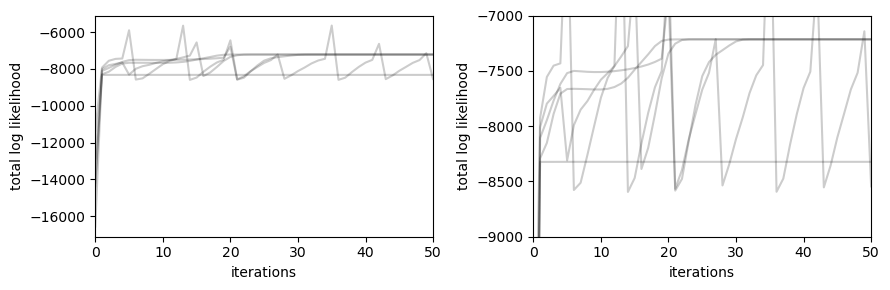

In [24]:
# plot log likelihoods for all random initializations to check if model converged
plt.figure(figsize=(9,3), dpi=100)
plt.subplot(1,2,1)
plt.plot(np.array(LLs).T, 'k-', alpha=.2)
plt.xlabel('iterations')
plt.ylabel('total log likelihood')
plt.xlim(0,50)
plt.subplot(1,2,2)
plt.plot(np.array(LLs).T, 'k-', alpha=.2)
plt.xlabel('iterations')
plt.ylabel('total log likelihood')
plt.xlim(0,50)
plt.ylim(-9000, -7000)
plt.tight_layout()

In [25]:
# select best model
best_model = np.argmax([ll[-1] for ll in LLs])
m, s, p = model[best_model]

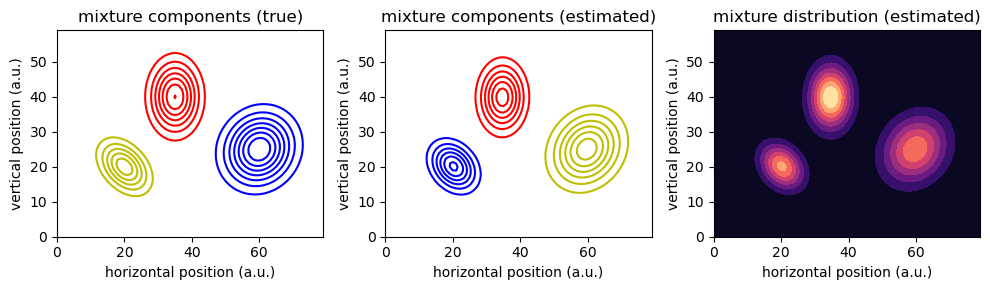

In [26]:
# plot initial means and covariances, as well as initial mixture distribution

# make 2D meshgrid
x, y = np.mgrid[0:80:1, 0:60:1]
vals = np.dstack((x, y))

# evaluate pdfs
pdfs = [sps.multivariate_normal.pdf(vals, m[k], s[k]) for k in range(K)]

# sum weighted pdfs for mixture distribution
mixture_pdf = np.sum([p[k]*pdfs[k] for k in range(K)], axis=0)

# true pdfs
pdfs_true = [sps.multivariate_normal.pdf(vals, mus[k], sigmas[k]) for k in range(K)]

plt.figure(figsize=(10,3), dpi=100)
plt.subplot(1,3,1)
for k,pdf in enumerate(pdfs_true):
    plt.contour(pdf.T, colors=colors[k])
plt.title('mixture components (true)')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')

plt.subplot(1,3,2)
for k,pdf in enumerate(pdfs):
    plt.contour(pdf.T, colors=colors[k])
plt.title('mixture components (estimated)')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')

plt.subplot(1,3,3)
plt.contourf(mixture_pdf.T, cmap='magma')
plt.title('mixture distribution (estimated)')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.tight_layout()

## Custom mixtures

We could easily customize our mixture model to incorporate different mixture distributions than Gaussians, for example a Student-t distribution. Here, the center of the object would have a higher saccade density, whereas the margins of the saccade distribution seem to be flatter.

We could model a mixture of one Student-t component and two Gaussian components:

\begin{align}
p(\boldsymbol{x}) = \pi_{1} \mathcal{N}(\boldsymbol{x} | \mu_1, \Sigma_1) + \pi_{2} \mathcal{N}(\boldsymbol{x} | \mu_2, \Sigma_2) + \pi_{3} \mathcal{St}(\boldsymbol{x} | \mu_3, \Sigma_3, \nu)
\end{align}

The Student-t distribution $\mathcal{St}(\boldsymbol{x} | \mu, \Sigma, \nu)$ has parameters $\mu$ and $\Sigma$, just like the Gaussian, and an additional parameter $\nu \in \mathbb{R}_{+}$ (called degrees of freedom). For $\nu\to\infty$, the Student-t distribution becomes a Gaussian, while it is significantly more "peaked" with flat margins for $\nu\to0$. You can evaluate its probability density function by calling `sps.multivariate_t.pdf(x, mu, sigma, nu)`.

In [27]:
# degrees of freedom parameter
nu = .9

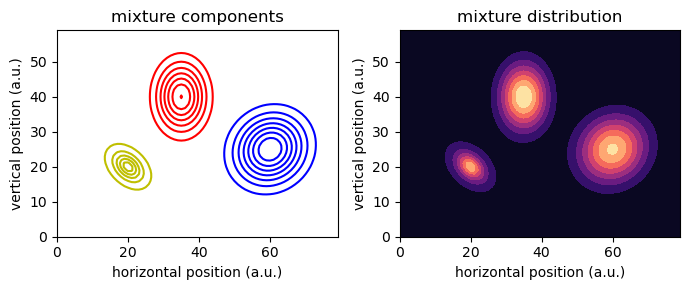

In [28]:
x, y = np.mgrid[0:80:1, 0:60:1]
vals = np.dstack((x, y))

# evaluate Gaussian pdfs
pdfs = [sps.multivariate_normal.pdf(vals, mus[k], sigmas[k]) for k in range(1,K)]
# add Student t pdf
pdfs.append(sps.multivariate_t.pdf(vals, mus[0], sigmas[0], nu))

# first component is Student t, others are Gaussian
pdfs = [pdfs[-1], pdfs[0], pdfs[1]]

# sum weighted pdfs for mixture distribution
mixture_pdf = np.sum([pis[k]*pdfs[k] for k in range(K)], axis=0)

plt.figure(figsize=(7,3), dpi=100)
plt.subplot(1,2,1)
for k,pdf in enumerate(pdfs):
    plt.contour(pdf.T, colors=colors[k])
plt.title('mixture components')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')

plt.subplot(1,2,2)
plt.contourf(mixture_pdf.T, cmap='magma')
plt.title('mixture distribution')
plt.xlabel('horizontal position (a.u.)')
plt.ylabel('vertical position (a.u.)')
plt.tight_layout()